# periderm

In [1]:
library(Signac)
library(Seurat)
library(scCustomize)
library(ggplot2)
library(patchwork)
library(harmony)
library(Matrix)
library(irlba)
library(BSgenome.Mmusculus.UCSC.mm10)
library(GenomicRanges)
library(dplyr)
library(pheatmap)
library(patchwork)
library(viridis)
library(ComplexHeatmap)
library(TxDb.Mmusculus.UCSC.mm10.knownGene)
library(org.Mm.eg.db)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


scCustomize v2.1.2
If you find the scCustomize useful please cite.
See 'samuel-marsh.github.io/scCustomize/articles/FAQ.html' for citation info.

Loading required package: Rcpp

Loading required package: BSgenome

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:SeuratObject’:

    intersect


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rowname

In [2]:
Process_RNA <- function(proj=proj, nfeatures=2000, pc.nums=50, dims=1:50, pca.name = 'pca', umap.name= 'umap.rna', res = 0.8){
  DefaultAssay(proj) <- "RNA"
  #
  proj <- NormalizeData(proj)
  proj <- FindVariableFeatures(proj, nfeatures = nfeatures)
  VariableFeatures(proj) <- VariableFeatures(proj)[!VariableFeatures(proj) %in% blacklist.genes]
  proj <- ScaleData(proj)
  proj <- RunPCA(proj, npcs = pc.nums, reduction.name = pca.name)
  #
  return(proj)
}
GetBlackListGenes <- function (proj = proj, MT = TRUE, Ribo = TRUE, Cellcycle = TRUE, Sex = TRUE) {
    mt.genes <- grep(pattern = "^MT-", x = rownames(proj), value = TRUE)
    ribosome.genes <- grep(pattern = "^RP[SL][[:digit:]]|^RP[[:digit:]]|^RPSA", 
        rownames(proj), value = TRUE)
    s.genes <- cc.genes$s.genes
    g2m.genes <- cc.genes$g2m.genes
    txdb <- TxDb.Mmusculus.UCSC.mm10.knownGene
    geneGR <- GenomicFeatures::genes(txdb)
    sexGenesGR <- geneGR[seqnames(geneGR) %in% c("chrY", "chrX")]
    matchedGeneSymbols <- AnnotationDbi::select(org.Mm.eg.db, 
        keys = sexGenesGR$gene_id, columns = c("ENTREZID", "SYMBOL"), keytype = "ENTREZID")
    sexChr.genes <- matchedGeneSymbols$SYMBOL
    vector_genes = c(MT, Ribo, Sex, Cellcycle, Cellcycle)
    order_num = c()
    for (i in 1:length(vector_genes)) {
        if (isTRUE(vector_genes[i])) {
            order_num <- c(order_num, i)
        }
    }
    blacklist.genes <- list(mt.genes, ribosome.genes, sexChr.genes, s.genes, g2m.genes)[order_num]
    blacklist.genes <- do.call(c, blacklist.genes)
    return(blacklist.genes)
}

In [3]:
seu <- readRDS('./03_Skin/Mskin_rna_atac.rds')
periderm = seu[, seu@meta.data$rna_celltype %in% c("Periderm")]
saveRDS(periderm,'./03_Skin/Mskin_periderm.rds')

In [4]:
periderm <- readRDS('./03_Skin/Mskin_periderm.rds')

In [5]:
periderm
colnames(periderm@meta.data)

An object of class Seurat 
225161 features across 591 samples within 3 assays 
Active assay: RNA (28250 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: ATAC, aRNA
 6 dimensional reductions calculated: pca, harmony, umap, integrated_lsi, umap.atac, wnn.umap

[1] "orig.ident"        "nCount_RNA"        "nFeature_RNA"     
 [4] "batch"             "percent.mt"        "percent.ribo"     
 [7] "percent_mito"      "percent_ribo"      "percent_mito_ribo"
[10] "log10GenesPerUMI"  "outlier"           "scDblFinder.class"
[13] "scDblFinder.score" "RNA_snn_res.0.1"   "RNA_snn_res.0.3"  
[16] "RNA_snn_res.0.5"   "seurat_clusters"   "predicted.id"     
[19] "rna_celltype"      "ATAC_snn_res.0.1"  "ATAC_snn_res.0.3" 
[22] "ATAC_snn_res.0.5"  "ATAC_snn_res.0.8"  "nCount_ATAC"      
[25] "nFeature_ATAC"     "atac_celltype"     "stage"            
[28] "RNA.weight"        "ATAC.weight"       "wsnn_res.0.1"     
[31] "wsnn_res.0.3"      "wsnn_res.0.5"

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


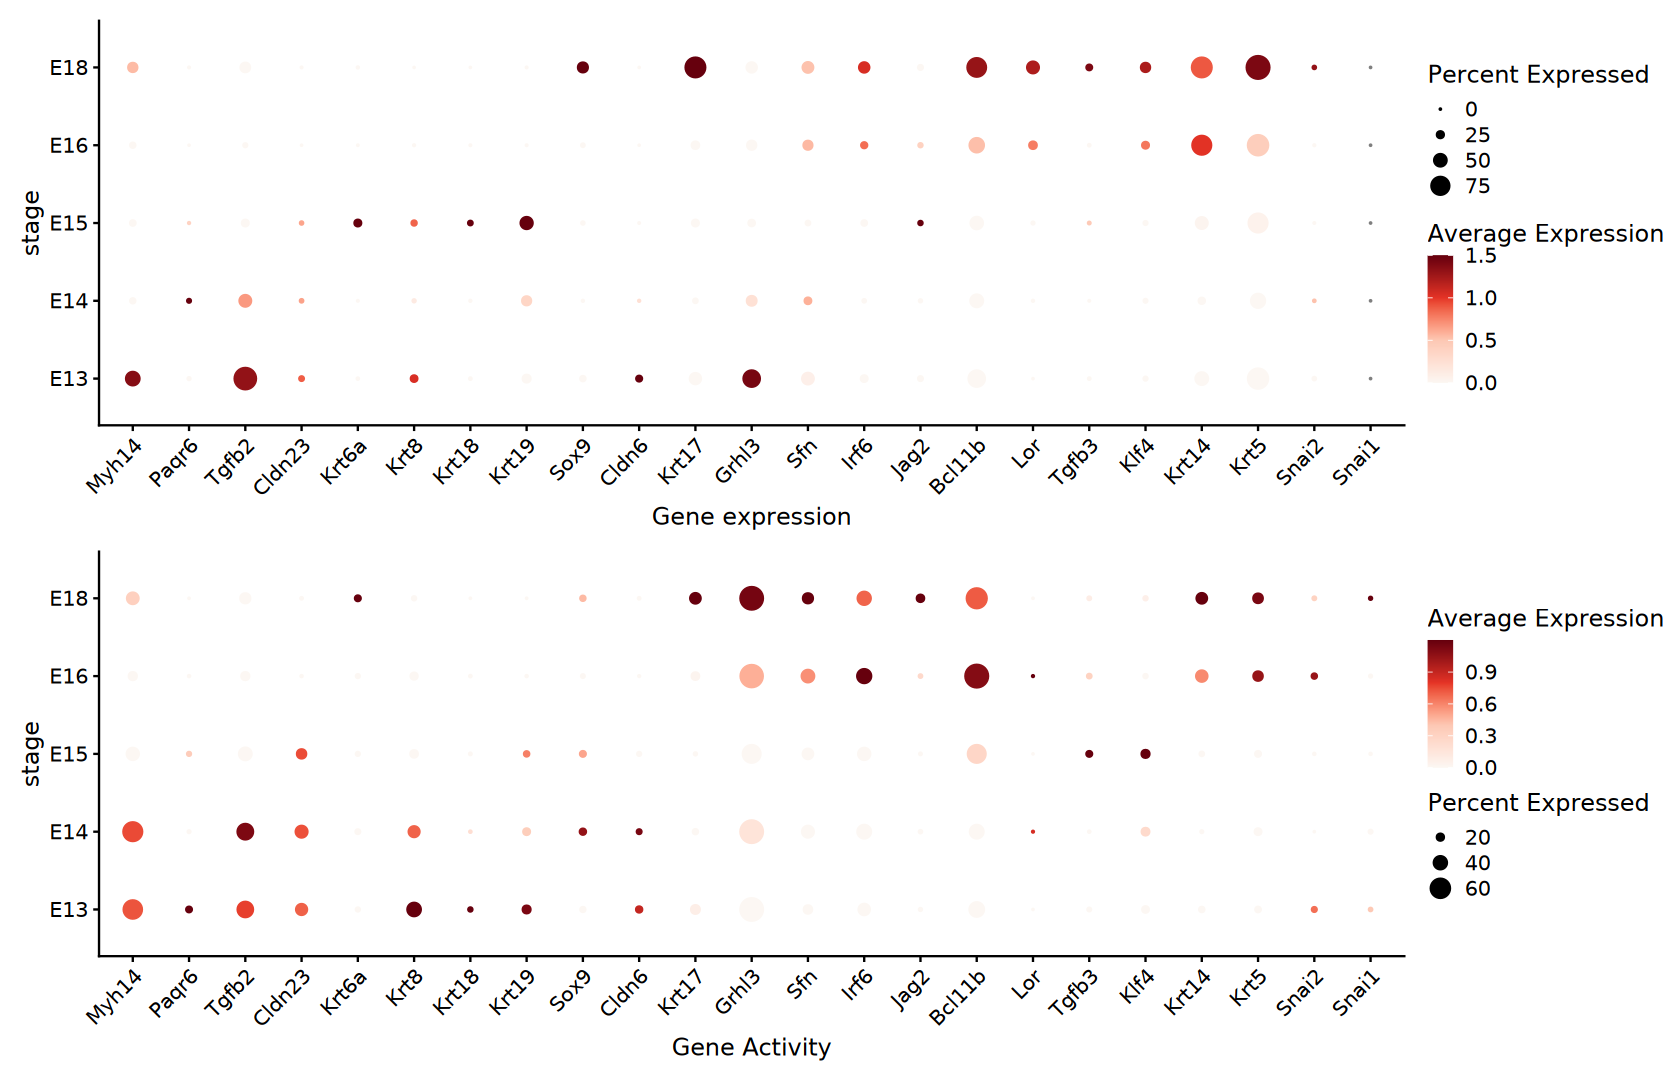

In [6]:
DefaultAssay(periderm) <- 'RNA'
options(repr.plot.width=14, repr.plot.height=9)
makerlist1<- c('Myh14','Paqr6','Tgfb2','Cldn23','Krt6a','Krt8','Krt18','Krt19','Sox9','Cldn6','Krt17','Grhl3','Sfn','Irf6','Jag2','Bcl11b','Lor','Tgfb3','Klf4','Krt14','Krt5','Snai2','Snai1')
p1 <- Seurat::DotPlot(periderm, features = makerlist1, group.by='stage', scale = TRUE, cluster.idents=FALSE, col.min = 0,col.max=1.5) + RotatedAxis() +
     scale_color_gradientn(colours = c(colours = c(rgb(252/255, 247/255, 243/255),rgb(253/255, 200/255, 180/255),rgb(229/255, 51/255, 38/255),rgb(102/255, 0/255, 13/255)))) +
     xlab('Gene expression') + ylab('stage') + scale_y_discrete(limits=rev(levels(periderm$stage))) + scale_x_discrete(limits=makerlist1) 
DefaultAssay(periderm) <- 'aRNA'
p2 <- Seurat::DotPlot(periderm, features = makerlist1, group.by='stage', scale = TRUE, cluster.idents=FALSE, col.min = 0,col.max = 1.2) + RotatedAxis() +
     scale_color_gradientn(colours = c(colours = c(rgb(252/255, 247/255, 243/255),rgb(253/255, 200/255, 180/255),rgb(229/255, 51/255, 38/255),rgb(102/255, 0/255, 13/255))))  +
     xlab('Gene Activity') + ylab('stage') + scale_y_discrete(limits=rev(levels(periderm$stage))) + scale_x_discrete(limits=makerlist1)
p1/p2
ggsave('./03_Skin/periderm_stage_marker.pdf',p1/p2,width=14,height=9,dpi=600)

# periderm (E15-E18)

In [7]:
periderm$stage

E13_HU1_BC0214_N02   E13_HU1_BC0239_N02   E13_HU1_BC0331_N02 
               "E13"                "E13"                "E13" 
  E13_HU1_BC0468_N03   E13_HU1_BC0647_N01   E13_HU1_BC0717_N01 
               "E13"                "E13"                "E13" 
  E13_HU1_BC0745_N01   E13_HU1_BC0753_N02   E13_HU1_BC1013_N01 
               "E13"                "E13"                "E13" 
  E13_HU1_BC1040_N02   E13_HU1_BC1088_N01   E13_HU1_BC1145_N02 
               "E13"                "E13"                "E13" 
  E13_HU1_BC1164_N01   E13_HU1_BC1318_N01   E13_HU1_BC1375_N02 
               "E13"                "E13"                "E13" 
  E13_HU1_BC1547_N05   E13_HU1_BC1765_N05   E13_HU1_BC1932_N01 
               "E13"                "E13"                "E13" 
  E13_HU1_BC2076_N02   E13_HU1_BC2096_N01   E13_HU1_BC2393_N01 
               "E13"                "E13"                "E13" 
  E13_HU1_BC2431_N03   E13_HU1_BC2484_N01   E13_HU1_BC2491_N02 
               "E13"                "E13"                "E13" 
  E13_HU1_BC2920_N01   E13_HU1_BC3100_N03   E13_HU1_BC3220_N02 
               "E13"                "E13"                "E13" 
  E13_HU1_BC3234_N04   E13_HU1_BC3264_N02   E13_HU1_BC3266_N03 
               "E13"                "E13"                "E13" 
  E13_HU1_BC3299_N03   E13_HU1_BC3406_N02   E13_HU1_BC3412_N01 
               "E13"                "E13"                "E13" 
  E13_HU1_BC3425_N01   E13_HU1_BC3451_N01   E13_HU1_BC3458_N03 
               "E13"                "E13"                "E13" 
  E13_HU1_BC3945_N02   E13_HU1_BC4038_N01   E13_HU1_BC4079_N01 
               "E13"                "E13"                "E13" 
  E13_HU1_BC4314_N03   E13_HU1_BC4324_N02   E13_HU1_BC4366_N02 
               "E13"                "E13"                "E13" 
  E13_HU1_BC4552_N03   E13_HU1_BC4569_N01   E13_HU1_BC4641_N01 
               "E13"                "E13"                "E13" 
  E13_HU1_BC4713_N01   E13_HU1_BC4779_N02   E13_HU1_BC5001_N04 
               "E13"                "E13"                "E13" 
  E13_HU1_BC5044_N02   E13_HU1_BC5433_N01   E13_HU1_BC5510_N01 
               "E13"                "E13"                "E13" 
  E13_HU2_BC0589_N01   E13_HU2_BC0642_N03   E13_HU2_BC0680_N02 
               "E13"                "E13"                "E13" 
  E13_HU2_BC0720_N01   E13_HU2_BC0864_N01   E13_HU2_BC0997_N01 
               "E13"                "E13"                "E13" 
  E13_HU2_BC1113_N01   E13_HU2_BC1172_N01   E13_HU2_BC1281_N01 
               "E13"                "E13"                "E13" 
  E13_HU2_BC1284_N01   E13_HU2_BC1349_N01   E13_HU2_BC1434_N02 
               "E13"                "E13"                "E13" 
  E13_HU2_BC1436_N01   E13_HU2_BC1523_N03   E13_HU2_BC1603_N02 
               "E13"                "E13"                "E13" 
  E13_HU2_BC1620_N01   E13_HU2_BC1718_N02   E13_HU2_BC1753_N01 
               "E13"                "E13"                "E13" 
  E13_HU2_BC1775_N02   E13_HU2_BC1780_N03   E13_HU2_BC1847_N01 
               "E13"                "E13"                "E13" 
  E13_HU2_BC1896_N03   E13_HU2_BC1931_N04   E13_HU2_BC1967_N02 
               "E13"                "E13"                "E13" 
  E13_HU2_BC2056_N03   E13_HU2_BC2106_N03   E13_HU2_BC2284_N02 
               "E13"                "E13"                "E13" 
  E13_HU2_BC2412_N01   E13_HU2_BC2437_N01   E13_HU2_BC2440_N01 
               "E13"                "E13"                "E13" 
  E13_HU2_BC2474_N03   E13_HU2_BC2537_N01   E13_HU2_BC2551_N02 
               "E13"                "E13"                "E13" 
  E13_HU2_BC2583_N01   E13_HU2_BC2631_N03   E13_HU2_BC2689_N02 
               "E13"                "E13"                "E13" 
  E13_HU2_BC2734_N04   E13_HU2_BC2842_N02   E13_HU2_BC2973_N01 
               "E13"                "E13"                "E13" 
  E13_HU2_BC3006_N03   E13_HU2_BC3078_N02   E13_HU2_BC3351_N03 
               "E13"                "E13"                "E13" 
  E13_HU2_BC3437_N01   E13_HU2_BC3

In [8]:
periderm_later = periderm[,periderm@meta.data$stage %in% c("E15","E16","E18")]
periderm_diff = periderm[,periderm@meta.data$atac_celltype %in% c("Basal","Spinous","Periderm")]

In [9]:
periderm_diff

An object of class Seurat 
225161 features across 245 samples within 3 assays 
Active assay: RNA (28250 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 2 other assays present: ATAC, aRNA
 6 dimensional reductions calculated: pca, harmony, umap, integrated_lsi, umap.atac, wnn.umap

  2135 genes were dropped because they have exons located on both strands
  of the same reference sequence or on more than one reference sequence,
  so cannot be represented by a single genomic range.
  Use 'single.strand.genes.only=FALSE' to get all the genes in a
  GRangesList object, or use suppressMessages() to suppress this message.

'select()' returned 1:1 mapping between keys and columns

Centering and scaling data matrix

PC_ 1 
Positive:  mt-Cytb, Jun, Robo2, Col1a1, Sox5, Adamts1, Col3a1, Krt79, mt-Co3, Robo1 
	   Flg, Arl15, Bach2, Krt1, Col1a2, Arl5b, Flrt3, Zswim6, Ptch1, Sparc 
	   Slco3a1, Casz1, Csgalnact1, Pik3r3, Krt17, Egr1, Nrp2, Atf3, Rtn4, Arhgap24 
Negative:  Krt19, Upk1b, Slc2a3, Krt4, Mal, Serpinb11, Ikzf2, Malat1, Msln, Ppl 
	   Upk3b, Dsc2, Ccser1, Emp1, Cd36, Wnk1, Krt6a, Ahnak, Mall, Spink5 
	   Krt7, Anxa1, Usp6nl, Arhgap40, Evpl, Cldn4, Psca, Bcl2l1, S100a6, Sh3tc2 
PC_ 2 
Positive:  Krt1, Krt10, Krt14, Cstdc5, Slc7a11, Kirrel3, Spidr, Slc24a3, Stfa3, Den

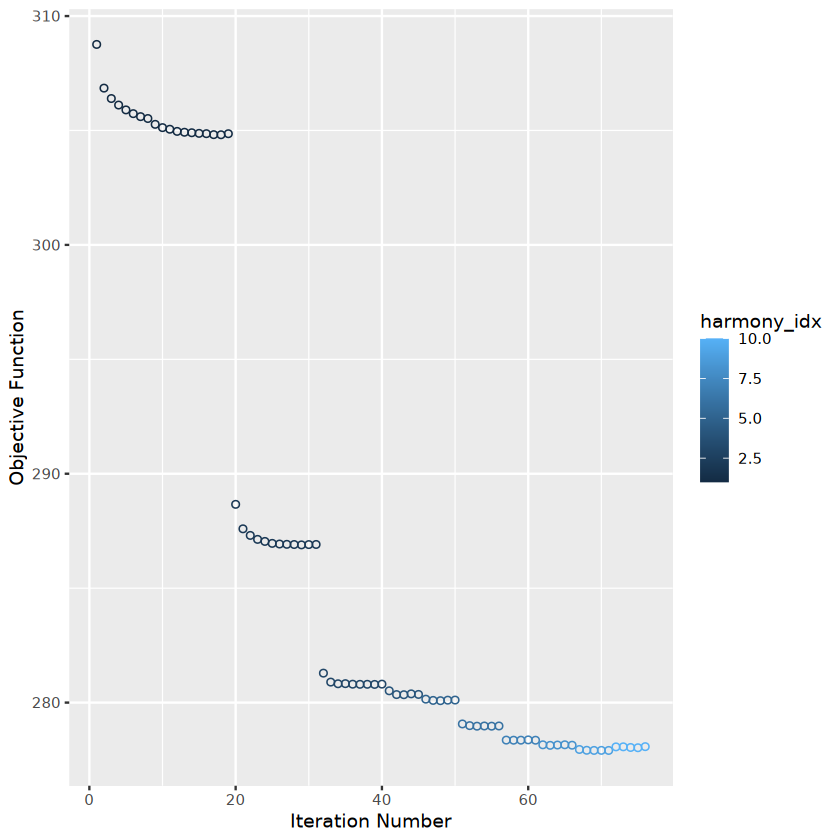

In [10]:
DefaultAssay(periderm_diff) <- 'RNA'
# get blacklist genes
blacklist.genes=GetBlackListGenes(periderm_diff, MT=TRUE, Ribo=TRUE, Cellcycle=FALSE, Sex=FALSE)
# process
periderm_diff=Process_RNA(periderm_diff)
var_int <- c("batch") # stage
# run harmony
periderm_diff <- RunHarmony(periderm_diff, group.by.vars = var_int, assay.use="RNA", reduction = "pca", plot_convergence = TRUE)

In [11]:
red_use <- "harmony"
dims_use <- 1:30
nneigh <- 40
periderm_diff <- RunUMAP(periderm_diff, reduction = red_use, dims = dims_use,n.neighbors = nneigh)
periderm_diff <- FindNeighbors(periderm_diff, verbose = T, reduction = red_use, dims = dims_use)
periderm_diff <- FindClusters(periderm_diff, verbose = T, algorithm = 3, resolution = c(0.1, 0.3, 0.5))

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
14:27:53 UMAP embedding parameters a = 0.9922 b = 1.112

14:27:53 Read 245 rows and found 30 numeric columns

14:27:53 Using Annoy for neighbor search, n_neighbors = 40

14:27:53 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:27:53 Writing NN index file to temp file /jdfssz1/ST_SUPERCELLS/P21Z10200N0090/Automated/USER/zhangzhongjin/RTEMP/Rtmp7BR8lM/file48ea25ba86cb

14:27:53 Searching Annoy index using 1 thread, search_k = 4000

14:27:53 Annoy recall = 100%

14:27:56 Commencing smooth

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 245
Number of edges: 15423

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.9000
Number of communities: 1
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 245
Number of edges: 15423

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.7371
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 245
Number of edges: 15423

Running smart local moving algorithm...
Maximum modularity in 10 random starts: 0.5858
Number of communities: 2
Elapsed time: 0 seconds


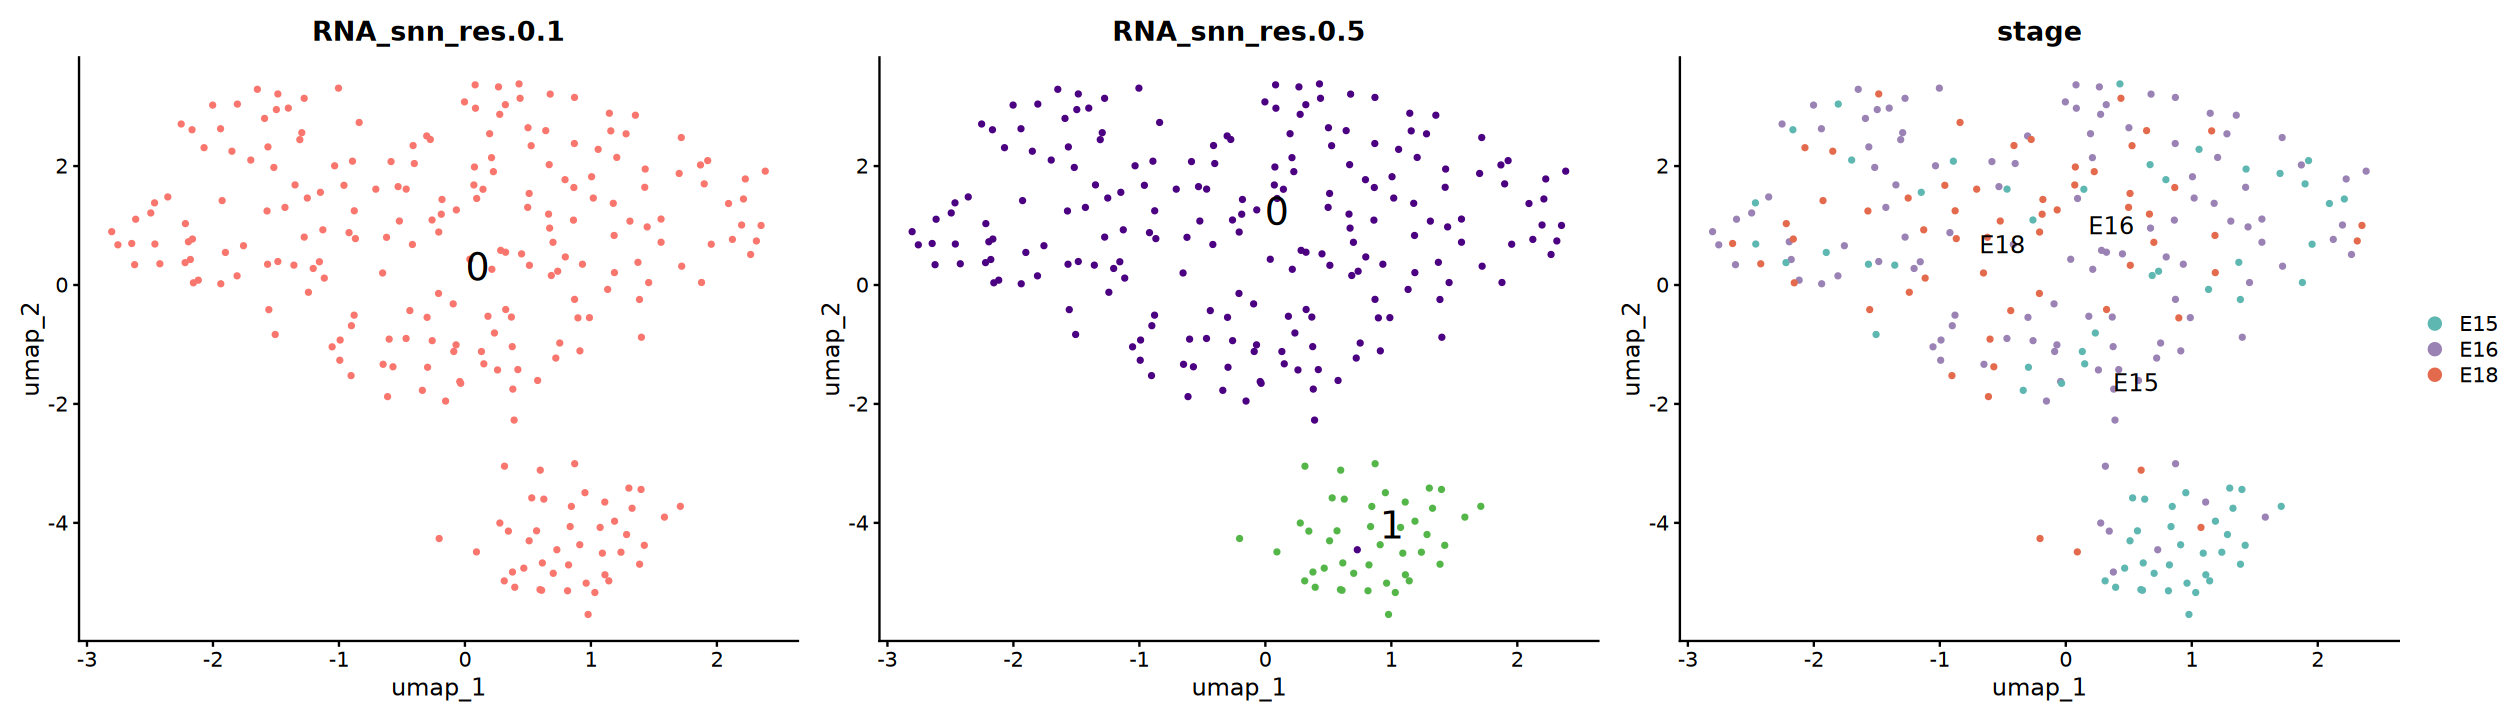

In [12]:
# plot
DefaultAssay(periderm_diff) <- "RNA"
options(repr.plot.width=21, repr.plot.height=6)
options(ggrepel.max.overlaps = Inf)
p1=DimPlot(periderm_diff, label.size = 8, repel=TRUE, group.by = 'RNA_snn_res.0.1', label=TRUE) + NoLegend()
p2=DimPlot(periderm_diff, label.size = 8, repel=TRUE, group.by = 'RNA_snn_res.0.5', label=TRUE, cols= c('#4b0082','#54b649')) + NoLegend()
p3=DimPlot(periderm_diff, label.size = 5, repel=TRUE, group.by = 'stage', label=TRUE,cols= c('#5EB7B1', '#9B82B5', '#E46A4D'))#"#2dabb2",'#407bae','#ac592a'
p1|p2|p3
# ggsave('./03_Skin/periderm_later_RNA.pdf',p1|p2|p3,width=21,height=6)

Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
“Some features contain 0 total counts”
Running SVD

Scaling cell embeddings

Harmony 1/10

Harmony 2/10

Harmony 3/10

Harmony 4/10

Harmony 5/10

Harmony 6/10

Harmony 7/10

Harmony converged after 7 iterations



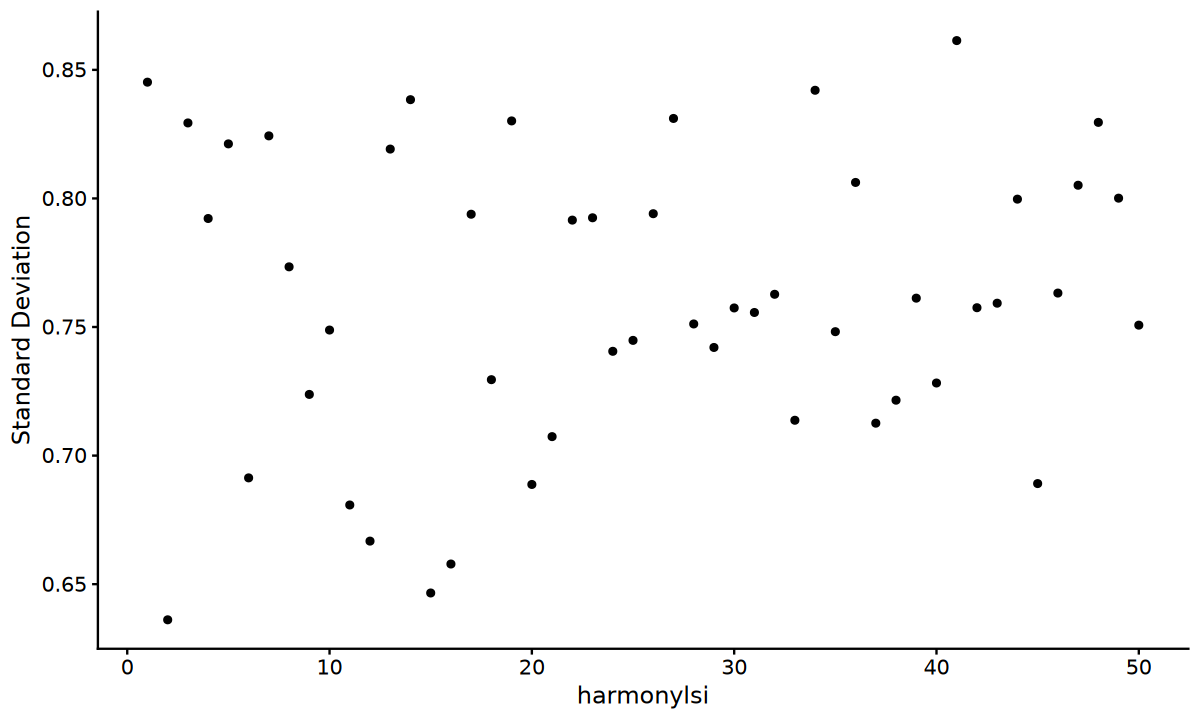

14:28:14 UMAP embedding parameters a = 0.9922 b = 1.112

14:28:14 Read 245 rows and found 25 numeric columns

14:28:14 Using Annoy for neighbor search, n_neighbors = 30

14:28:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

14:28:14 Writing NN index file to temp file /jdfssz1/ST_SUPERCELLS/P21Z10200N0090/Automated/USER/zhangzhongjin/RTEMP/Rtmp7BR8lM/file48ea6045d30a

14:28:14 Searching Annoy index using 1 thread, search_k = 3000

14:28:14 Annoy recall = 100%

14:28:16 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

14:28:21 Initializing from normalized Laplacian + noise (using RSpectra)

14:28:21 Commencing optimization for 500 epochs, with 8884 positive edges

14:28:24 Optimization finished

Warning message:
“The following a

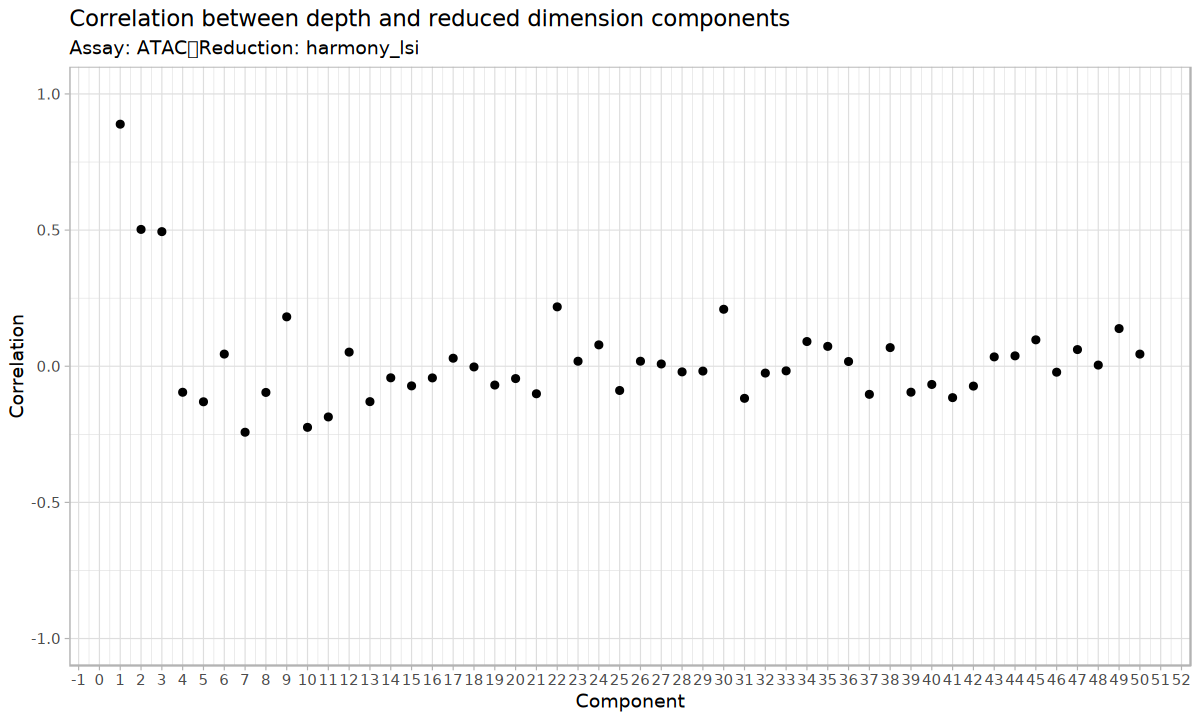

In [13]:
DefaultAssay(periderm_diff) <- "ATAC"
## LSI reduction
periderm_diff <- RunTFIDF(periderm_diff)
periderm_diff <- FindTopFeatures(periderm_diff, min.cutoff = 'q50')
periderm_diff <- RunSVD(periderm_diff)
# run harmony
var_int <- "batch"
#var_int <- "stage"
periderm_diff <- RunHarmony(periderm_diff, group.by.vars = var_int, assay.use="ATAC", reduction = "lsi", reduction.save = 'harmony_lsi', project.dim = FALSE)
options(repr.plot.width=10, repr.plot.height=6)
ElbowPlot(periderm_diff, ndims = 50, reduction = 'harmony_lsi')
DepthCor(periderm_diff, reduction='harmony_lsi', n=50)
# create a new UMAP using the integrated embeddings
periderm_diff <- RunUMAP(periderm_diff, reduction = 'harmony_lsi', dims = c(2:26), reduction.name = "umap.atac", reduction.key = "atacUMAP_")
periderm_diff <- FindNeighbors(periderm_diff, reduction = 'harmony_lsi', dims = c(2:26), n.neighbors = 40)
periderm_diff <- FindClusters(periderm_diff, verbose = FALSE, algorithm = 3, resolution = c(0.1, 0.3, 0.5))

In [14]:
periderm_diff$ATAC_cell_type <- ifelse(periderm_diff$ATAC_snn_res.0.5 %in% c(2, 4), "periderm1", 
                                      ifelse(periderm_diff$ATAC_snn_res.0.5 %in% c(0, 3), "periderm2", 
                                             ifelse(periderm_diff$ATAC_snn_res.0.5 %in% c(1), "periderm3", NA)))

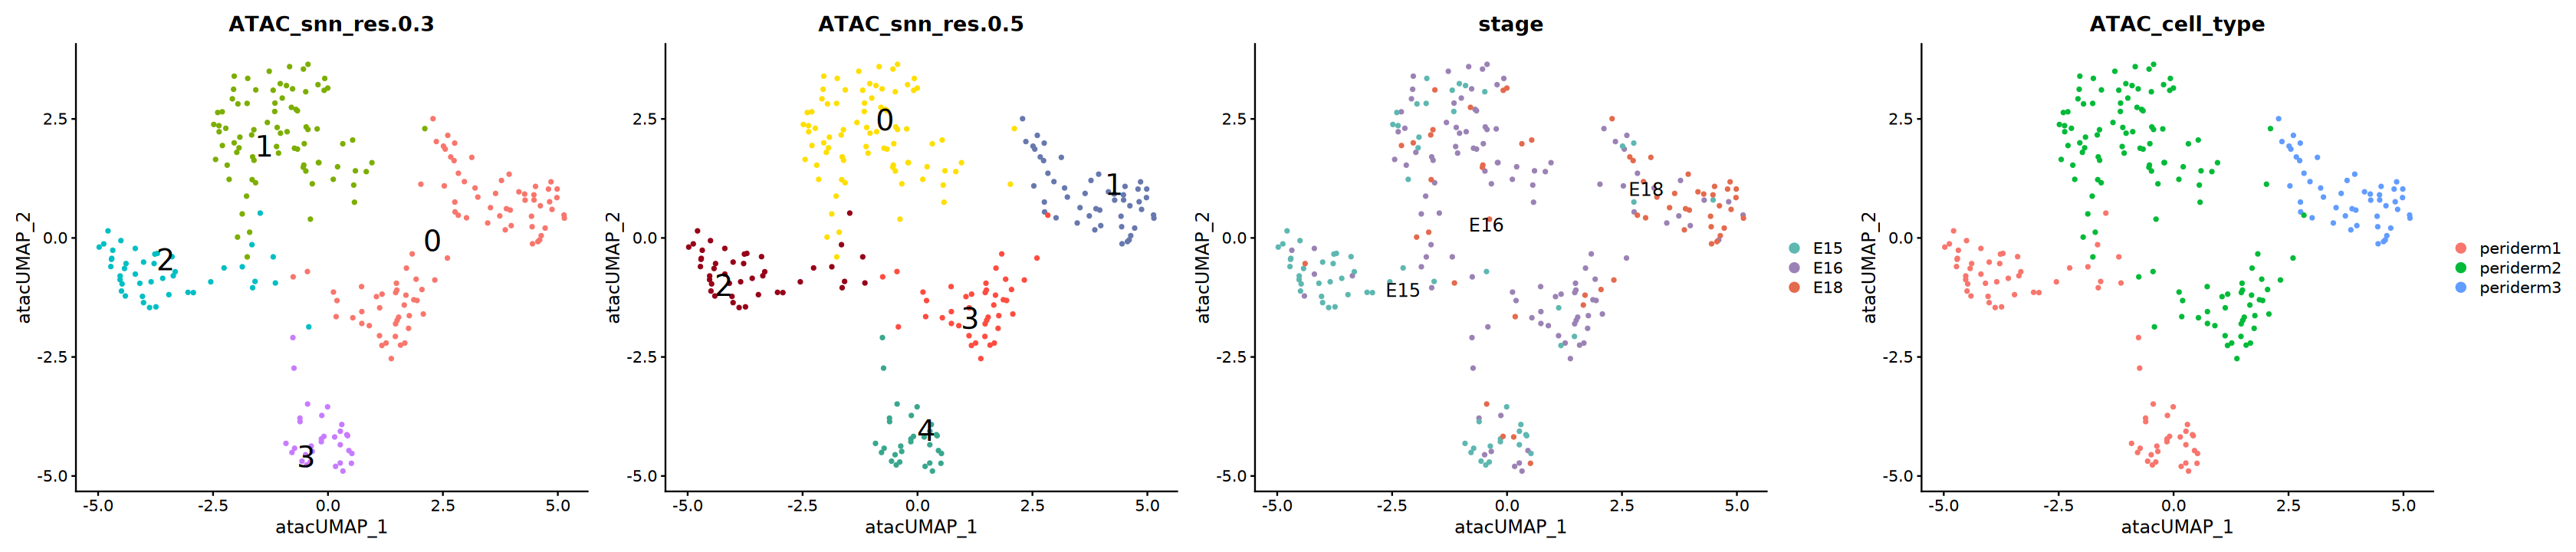

In [15]:
DefaultAssay(periderm_diff) <- "ATAC"
options(repr.plot.width=28, repr.plot.height=6)
options(ggrepel.max.overlaps = Inf)
p1=DimPlot(periderm_diff, label.size = 8, repel=TRUE, group.by = 'ATAC_snn_res.0.3', label=TRUE) + NoLegend()
p2=DimPlot(periderm_diff, label.size = 8, repel=TRUE, group.by = 'ATAC_snn_res.0.5', label=TRUE,cols= c('#960018', '#39a78e', '#fedf00', '#fe4c40', '#6778AE')) + NoLegend()
p3=DimPlot(periderm_diff, label.size = 5, repel=TRUE, group.by = 'stage', label=TRUE,cols= c('#5EB7B1', '#9B82B5', '#E46A4D'))
p4=DimPlot(periderm_diff, label.size = 5, repel=FALSE, group.by = 'ATAC_cell_type',label=FALSE) 
p1|p2|p3|p4
# ggsave('./03_Skin/periderm_later_ATAC.pdf',p1|p2|p3|p4,width=28,height=6)

In [16]:
table(periderm_diff$RNA_snn_res.0.5, periderm_diff$ATAC_snn_res.0.1)

   
      0   1
  0 173  29
  1  41   2

In [17]:
my36colors <- c('#53A85F', '#F1BB72', '#F3B1A0', '#D6E7A3', '#57C3F3', '#476D87', '#E95C59', '#E59CC4', '#E5D2DD', '#AB3282', '#BD956A', 
                '#8C549C', '#E0D4CA', '#C5DEBA', '#58A4C3', '#E4C755', '#AA9A59', '#E63863', '#E39A35', '#C1E6F3', '#6778AE', '#91D0BE', 
                '#B53E2B', '#712820', '#DCC1DD', '#CCE0F5', '#CCC9E6', '#625D9E', '#68A180', '#3A6963','#968175')
style = theme(axis.text.x = element_text(color = "grey20", size = 14, angle = 90, face = "plain"),
        axis.text.y = element_text(color = "grey20", size = 14, angle = 0, face = "plain"),  
        axis.title.x = element_text(color = "grey20", size = 14, angle = 0, face = "plain"),
        axis.title.y = element_text(color = "grey20", size = 14, angle = 90, face = "plain"),
        panel.grid = element_blank(),
        panel.background = element_rect(fill = "transparent",colour = NA),
        axis.line.x = element_line(colour = "black") ,
        axis.line.y = element_line(colour = "black") ,
        plot.title = element_text(lineheight=.8, face="bold", hjust=0.5, size =16),
        legend.text = element_text(size=14))

In [18]:
periderm_diff$ATAC_snn_res.0.5 <- factor(periderm_diff$ATAC_snn_res.0.5, levels = c('2', '4', '0', '3', '1'))

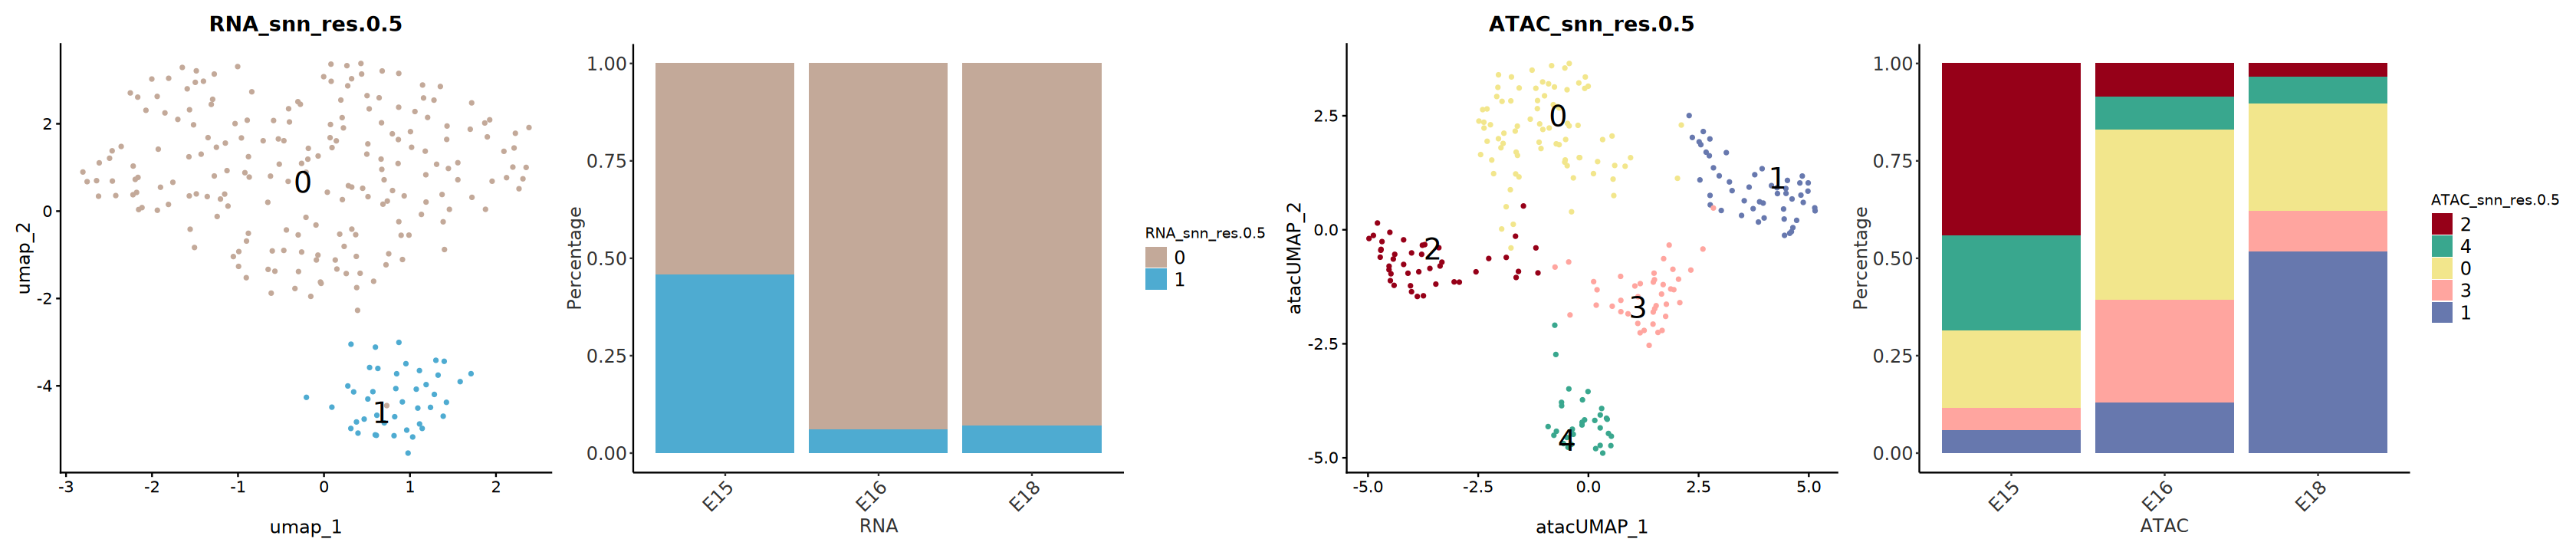

In [19]:
options(repr.plot.width=28, repr.plot.height=6)
DefaultAssay(periderm_diff) <- "RNA"
p1=DimPlot(periderm_diff, label.size = 8, repel=TRUE, group.by = 'RNA_snn_res.0.5', label=TRUE, cols= c('#c3a999','#4eabd1')) + NoLegend()
p2 <- ggplot(periderm_diff@meta.data,aes(x=stage,fill=RNA_snn_res.0.5)) + 
    geom_bar(position="fill") + scale_fill_manual(values=c('#c3a999','#4eabd1')) + 
    style + labs(y="Percentage") + RotatedAxis() + xlab(NULL) + xlab('RNA') 
DefaultAssay(periderm_diff) <- "ATAC"
p3=DimPlot(periderm_diff, label.size = 8, repel=TRUE, group.by = 'ATAC_snn_res.0.5', label=TRUE,cols= c('#960018', '#39a78e', '#f2e68c', '#ffa59f', '#6778AE')) + NoLegend()
p4 <- ggplot(periderm_diff@meta.data,aes(x=stage,fill=ATAC_snn_res.0.5)) + 
    geom_bar(position="fill") + scale_fill_manual(values=c('#960018', '#39a78e', '#f2e68c', '#ffa59f', '#6778AE')) + 
    style + labs(y="Percentage") + RotatedAxis() + xlab(NULL) + xlab('ATAC') 
p1|p2|p3|p4
ggsave('./03_Skin/periderm.pdf',p1|p2|p3|p4,width=28,height=6)

## differential genes/peaks analysis

In [20]:
periderm_diff <- readRDS('./03_Skin/periderm/Mskin_periderm_diff.rds')

In [21]:
table(periderm_diff$stage)
table(periderm_diff$ATAC_cell_type)
table(periderm_diff$ATAC_snn_res.0.5)
table(periderm_diff$ATAC_snn_res.0.3)


E15 E16 E18 
 70 117  58 


periderm1 periderm2 periderm3 
       74       122        49 


 0  1  2  3  4 
81 49 43 41 31 


 0  1  2  3 
90 80 44 31 

* ATAC

In [22]:
periderm_diff = periderm_diff[, periderm_diff$ATAC_snn_res.0.5 %in% c('0','1','3','4')]
periderm_diff$new <- periderm_diff$ATAC_snn_res.0.5
periderm_diff$new <- as.character(periderm_diff$new)
periderm_diff$new[periderm_diff$new == 4] <- 'S1'
periderm_diff$new[periderm_diff$new == 0 | periderm_diff$new == 3] <- 'S2'
periderm_diff$new[periderm_diff$new == 1] <- 'S3'

In [23]:
Idents(periderm_diff) <- 'ATAC_snn_res.0.5'
da_peak <- FindAllMarkers(object = periderm_diff, test.use = 'LR', latent.vars = 'nCount_ATAC')
write.csv(da_peak,file="./03_Skin/periderm/da_peaks_ATAC_snn_res.0.5.csv")

In [24]:
da_peak <- read.csv("./03_Skin/periderm/da_peaks_ATAC_snn_res.0.5.csv", row.names=1)
# top 20 genes
da_peak$cluster = as.factor(da_peak$cluster)
grouped_data <- da_peak %>% group_by(cluster) %>% slice_head(n = 200)
grouped_data
grouped_data$chrom <- sapply(strsplit(grouped_data$gene, "-"), function(x) x[1])
grouped_data$start <- sapply(strsplit(grouped_data$gene, "-"), function(x) x[2])
grouped_data$end <- sapply(strsplit(grouped_data$gene, "-"), function(x) x[3])
periderm_depeak <- grouped_data[c('chrom','start','end')]

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
2.237910e-08,2.677499,0.309,0.055,0.003918647,0,chr9-21015121-21017118
2.103573e-07,1.971119,0.370,0.110,0.036834199,0,chr4-156030601-156032526
2.772574e-07,12.352632,0.123,0.000,0.048548597,0,chr2-133715302-133715878
5.847407e-07,3.939654,0.185,0.012,0.102389853,0,chr1-118708765-118709763
8.864769e-07,3.919316,0.173,0.012,0.155224762,0,chr13-32934672-32935502
1.075402e-06,2.171250,0.296,0.073,0.188306032,0,chr7-24394371-24395214
1.487605e-06,12.211485,0.111,0.000,0.260484043,0,chr16-36491675-36492474
2.295613e-06,3.826253,0.160,0.012,0.401968671,0,chr9-35424562-35425182
2.357089e-06,-12.375731,0.000,0.165,0.412733369,0,chr2-28525218-28526504


In [25]:
da_peak$new <- da_peak$cluster
da_peak$new <- as.character(da_peak$new)
da_peak$new[da_peak$new == 4] <- 'S1'
da_peak$new[da_peak$new == 0 | da_peak$new == 3] <- 'S2'
da_peak$new[da_peak$new == 1] <- 'S3'
da_peak <- da_peak[da_peak$new != '2',]
da_peak <- da_peak[da_peak$avg_log2FC>0.1,]
da_peaks <- da_peak[order(da_peak$new,da_peak$p_val),]
da_peaks <- da_peaks %>% group_by(new) %>% slice_head(n = 500)

In [26]:
da_peaks

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene,new
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
1.594123e-06,2.136390,0.516,0.117,0.2791357,4,chr2-3283414-3285391,S1
1.759431e-06,5.955031,0.194,0.005,0.3080816,4,chr10-19915255-19915794,S1
2.081137e-06,1.662593,0.613,0.206,0.3644134,4,chr15-102624582-102626052,S1
2.252157e-06,2.397830,0.419,0.089,0.3943594,4,chr19-15941247-15941944,S1
7.315766e-06,5.297874,0.194,0.005,1.0000000,4,chr8-94896544-94897019,S1
8.753939e-06,4.110650,0.226,0.014,1.0000000,4,chr9-107475712-107476931,S1
1.094941e-05,3.083988,0.290,0.037,1.0000000,4,chr18-20114188-20115385,S1
1.197482e-05,1.698813,0.548,0.178,1.0000000,4,chr14-55603699-55604603,S1
2.627528e-05,2.251013,0.387,0.084,1.0000000,4,chr3-96557182-96558491,S1


In [27]:
da_peaks$chrom <- sapply(strsplit(da_peaks$gene, "-"), function(x) x[1])
da_peaks$start <- sapply(strsplit(da_peaks$gene, "-"), function(x) x[2])
da_peaks$end <- sapply(strsplit(da_peaks$gene, "-"), function(x) x[3])
# write.table(da_peaks[da_peaks$new == 'S2',][c('chrom','start','end')], file = "./03_Skin/periderm/periderm_S2.bed", sep = "\t", row.names = FALSE, col.names = FALSE, quote = FALSE)

Warning message:
“The input is a data frame, convert it to the matrix.”
'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Warning message:
“The input is a data frame, convert it to the matrix.”
'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Warning message:
“The input is a data frame, convert it to the matrix.”
'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is

png 
  2

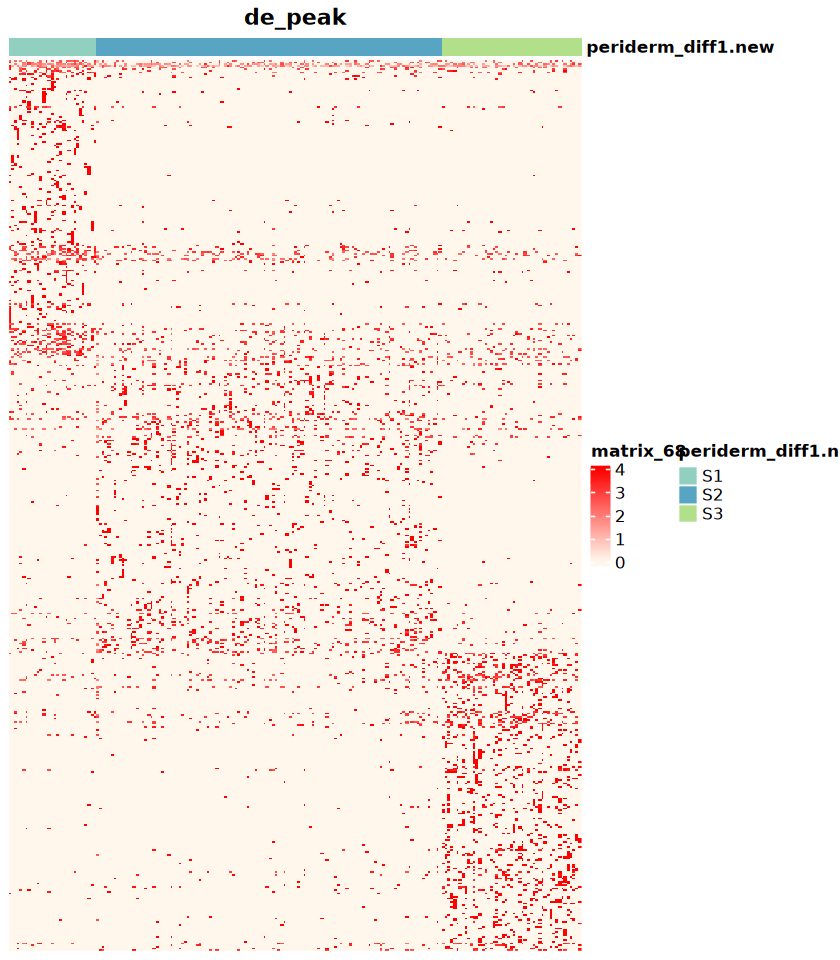

In [28]:
s1_h <- test[x1$gene,rownames(anno_col)]
wr = colorRampPalette(colors = c('#fff7ec',"red"))(100)
p1 = pheatmap(s1_h, cluster_rows = T, cluster_cols = F, show_rownames = F,
               color = wr, breaks = seq(0, 4, length = 101), 
               show_colnames = F, use_raster = TRUE,
               main='de_peak')
s2_h <- test[x2$gene,rownames(anno_col)]
wr = colorRampPalette(colors = c('#fff7ec',"red"))(100)
p2 = pheatmap(s2_h, cluster_rows = T, cluster_cols = F, show_rownames = F,
               color = wr, breaks = seq(0, 4, length = 101), 
               show_colnames = F, use_raster = TRUE,
               main='de_peak')
s3_h <- test[x3$gene,rownames(anno_col)]
wr = colorRampPalette(colors = c('#fff7ec',"red"))(100)
p3 = pheatmap(s3_h, cluster_rows = T, cluster_cols = F, show_rownames = F,
               color = wr, breaks = seq(0, 4, length = 101), 
               show_colnames = F, use_raster = TRUE,
               main='de_peak')
set.seed(123);row_idx <- row_order(p1)
rowid_dorc_list <- rownames(p1@matrix)[row_idx]
s1_h <- p1@matrix[row_idx,col_idx]
set.seed(123);row_idx <- row_order(p2)
rowid_dorc_list <- rownames(p2@matrix)[row_idx]
s2_h <- p2@matrix[row_idx,col_idx]
set.seed(123);row_idx <- row_order(p3)
rowid_dorc_list <- rownames(p3@matrix)[row_idx]
s3_h <- p3@matrix[row_idx,col_idx]
s_h <- rbind(s1_h,s2_h,s3_h)
label_colors <- list(periderm_diff1.new=c('S1' = '#91D0BE','S2' = '#58A4C3','S3' = '#B2DF8A','3' = '#6778AE',
  '4' = '#F7F398', '5' = '#CCE0F5'))
# wr = colorRampPalette(colors = c("#559696","Red"))(100)
# wr = colorRampPalette(colors = c('white',"red"))(100)
wr = colorRampPalette(colors = c('#fff7ec',"red"))(100)
p = pheatmap(s_h, cluster_rows = F, cluster_cols = F, show_rownames = F,
               color = wr, breaks = seq(0, 4, length = 101), 
               annotation_col = anno_col,show_colnames = F, annotation_colors = label_colors,use_raster = TRUE,
               main='de_peak')
p
pdf('./03_Skin/periderm/Mskin_periderm_depeak.pdf',width=8,height=8)
p
dev.off()

* RNA

In [29]:
periderm_diff

An object of class Seurat 
225161 features across 245 samples within 3 assays 
Active assay: ATAC (175103 features, 109354 variable features)
 2 layers present: counts, data
 2 other assays present: RNA, aRNA
 8 dimensional reductions calculated: pca, harmony, umap, integrated_lsi, umap.atac, wnn.umap, lsi, harmony_lsi

In [30]:
DefaultAssay(periderm_diff) <- 'RNA'
Idents(periderm_diff) <- 'RNA_snn_res.0.5'
da_gene <- FindAllMarkers(object = periderm_diff)
#write.csv(da_peak1,file="./03_Skin/da_peaks_RNA_snn_res.0.5.csv")

Calculating cluster 0

Calculating cluster 1



In [31]:
da_gene$cluster = as.factor(da_gene$cluster)
da_gene <- da_gene[da_gene$avg_log2FC>1,]
# da_gene$pct <- da_gene$pct.1-da_gene$pct.2
top20 <- da_gene %>% group_by(cluster) %>% slice_head(n = 20)
top20
# write.csv(grouped_data,file="./03_Skin/Mskin_periderm_RNA_dapeaks.csv")

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1.991275e-10,1.646751,0.941,0.674,5.625352e-06,0,Krt1
4.705014e-10,1.908870,0.916,0.581,1.329166e-05,0,Ext1
8.994631e-10,2.592315,0.782,0.349,2.540983e-05,0,Krt14
1.928434e-08,1.970218,0.802,0.349,5.447825e-04,0,Dst
4.331003e-08,1.636163,0.842,0.512,1.223508e-03,0,Slc38a2
2.452822e-07,1.576185,0.797,0.442,6.929223e-03,0,Dsc3
3.999936e-07,1.753281,0.733,0.349,1.129982e-02,0,Tenm2
5.328735e-07,1.225979,0.941,0.744,1.505368e-02,0,Krt10
8.580526e-07,1.228907,0.891,0.512,2.423999e-02,0,mt-Cytb


In [32]:
s1_h <- test[x1$gene,rownames(anno_col)]
wr = colorRampPalette(colors = c('#fff7ec',"red"))(100)
p1 = pheatmap(s1_h, cluster_rows = T, cluster_cols = F, show_rownames = F,
               color = wr, breaks = seq(0, 4, length = 101), 
               show_colnames = F, use_raster = TRUE,
               main='de_peak')
s2_h <- test[x2$gene,rownames(anno_col)]
wr = colorRampPalette(colors = c('#fff7ec',"red"))(100)
p2 = pheatmap(s2_h, cluster_rows = T, cluster_cols = F, show_rownames = F,
               color = wr, breaks = seq(0, 4, length = 101), 
               show_colnames = F, use_raster = TRUE,
               main='de_peak')

set.seed(123);row_idx <- row_order(p1)
rowid_dorc_list <- rownames(p1@matrix)[row_idx]
s1_h <- p1@matrix[row_idx,]
set.seed(123);row_idx <- row_order(p2)
rowid_dorc_list <- rownames(p2@matrix)[row_idx]
s2_h <- p2@matrix[row_idx,]
s_h <- rbind(s1_h,s2_h)

label_colors <- list(periderm_diff1.new=c('S1' = '#91D0BE','S2' = '#58A4C3','S3' = '#B2DF8A','3' = '#6778AE',
  '4' = '#F7F398', '5' = '#CCE0F5'))
# wr = colorRampPalette(colors = c("#559696","Red"))(100)
# wr = colorRampPalette(colors = c('white',"red"))(100)
wr = colorRampPalette(colors = c('#fff7ec',"red"))(100)
p = pheatmap(s_h, cluster_rows = F, cluster_cols = F, show_rownames = F,
               color = wr, breaks = seq(0, 6, length = 101), 
               annotation_col = anno_col,show_colnames = F, annotation_colors = label_colors,use_raster = TRUE,
               main='de_gene')
pdf('./03_Skin/periderm/Mskin_periderm_degene.pdf',width=8,height=8)
p
dev.off()

Warning message:
“The input is a data frame, convert it to the matrix.”
'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Warning message:
“The input is a data frame, convert it to the matrix.”
'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
Warning message:
“The heatmap has not been initialized. You might have different results
if you repeatedly execute this function, e.g. when row_km/column_km was
set. It is more suggested to do as `ht = draw(ht); row_order(ht)`.”
'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



png 
  2

## peak GO_term

In [33]:
periderm_goterm <- read.csv('./03_Skin/periderm_peaks/periderm_stage_goterm.csv')

In [34]:
periderm_goterm

Description,X.LogP,Log.q.value.,Binom.Fold.Enrichment,Binom.Region.Set.Coverage,stage
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
"wound healing, spreading of cells",4.062078,1.607897,5.857191,0.016,S1
morphogenesis of an epithelial sheet,3.731388,1.406840,3.575292,0.024,S1
regulation of apoptotic signaling pathway,7.686497,4.949769,2.601034,0.086,S2
Wnt signaling pathway,5.847453,3.486389,2.509647,0.068,S2
keratinization,4.452593,2.462758,7.999556,0.014,S2
regulation of epidermal cell differentiation,4.255836,2.332021,4.076315,0.024,S2
epithelial cell differentiation,7.038483,4.830029,2.022634,0.128,S3
skin epidermis development,5.805128,3.843524,3.568881,0.040,S3
hair cycle process,5.708603,3.764850,3.515901,0.040,S3


In [35]:
library("viridis")

In [36]:
periderm_goterm$Description <- factor(periderm_goterm$Description, 
                                      levels=c('hair follicle development','hair cycle process','skin epidermis development','epithelial cell differentiation',
                                                'regulation of epidermal cell differentiation','keratinization','Wnt signaling pathway',
                                              'regulation of apoptotic signaling pathway','morphogenesis of an epithelial sheet','wound healing, spreading of cells'))

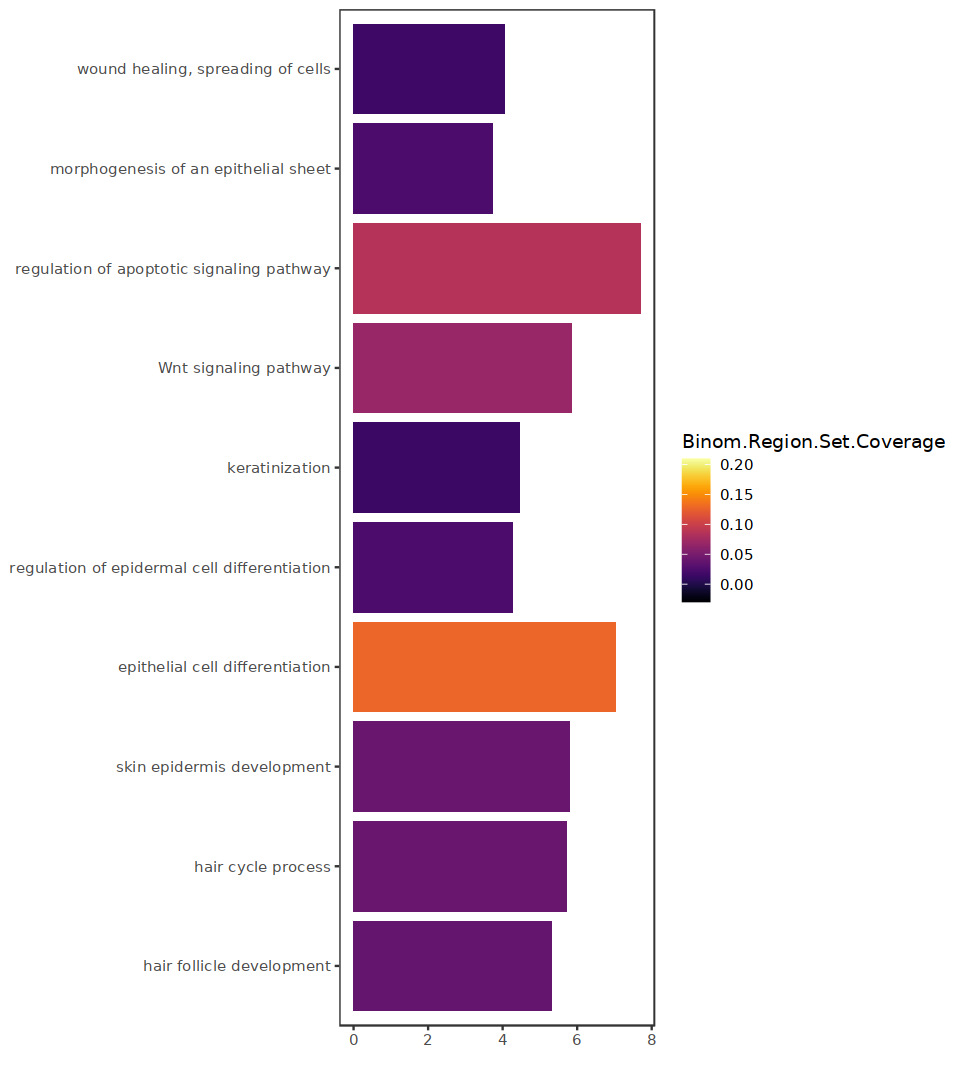

In [37]:
options(repr.plot.width = 8, repr.plot.height = 9)
p1= ggplot(periderm_goterm[order(periderm_goterm$Description), ], aes(Description, X.LogP)) + geom_col(aes(fill=Binom.Region.Set.Coverage))+ scale_fill_viridis(limits = c(-0.03, 0.21),option = "B")+
coord_flip() + theme_bw()  +
theme(panel.grid.major=element_line(colour=NA),panel.background = element_rect(fill = "transparent",colour = NA),
      plot.background = element_rect(fill = "transparent",colour = NA),panel.grid.minor = element_blank()) + xlab("") + ylab("")
p1
ggsave('./03_Skin/periderm_peaks/periderm_stage_goterm.pdf',p1,width=8,height=9)